In [1]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras import backend as K

def load_driving_log(path='./data', split='\\'):
    csv = pd.read_csv(os.path.join(path, 'driving_log.csv'), header=None,
                          names=['center','left','right','angle','throttle','break','speed'])

    csv.center = csv.center.str.split(split).str[-1]
    csv.left = csv.left.str.split(split).str[-1]
    csv.right = csv.right.str.split(split).str[-1]
    return csv

def generator(samples, path='./data', batch_size=32):
    num_samples = len(samples)
    print(num_samples)
    while 1:
        shuffle(samples)
    
        for offset in range(0, num_samples, batch_size):

            images = []
            angles = []
            batch_samples = samples[offset:offset + batch_size]

            for batch_sample in batch_samples:
                name = os.path.join(path, 'IMG', batch_sample[0])
                image = cv2.resize(cv2.imread(name), (200, 100), interpolation=cv2.INTER_AREA)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                images.append(image)
                angle = float(batch_sample[3])
                angles.append(angle)

            yield shuffle(np.array(images), np.array(angles))

Using TensorFlow backend.


In [3]:
driving_log = load_driving_log()
driving_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 7 columns):
center      11127 non-null object
left        11127 non-null object
right       11127 non-null object
angle       11127 non-null float64
throttle    11127 non-null float64
break       11127 non-null int64
speed       11127 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 608.6+ KB


In [4]:
train_samples, validation_samples = train_test_split(driving_log, test_size=0.2)

In [5]:
print('Driving log length:', len(driving_log))
print('Training samples length:', len(train_samples))
print('Validation samples length:', len(validation_samples))

Driving log length: 11127
Training samples length: 8901
Validation samples length: 2226


In [45]:
print(list(train_samples))
train_generator = generator(list(train_samples), batch_size=32)
validation_generator = generator(list(validation_samples), batch_size=32)

['center', 'left', 'right', 'angle', 'throttle', 'break', 'speed']


In [56]:
# 1. define basic model
model = Sequential()
# 6. add cropping
model.add(Cropping2D(cropping=((70, 25), (0, 0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x / 255 - 0.5, trainable=False))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid"))
model.add(ELU())
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid"))
model.add(ELU())
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid"))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, border_mode="valid"))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, border_mode="valid"))
model.add(Dropout(0.2))
model.add(ELU())
model.add(Flatten())
model.add(Dense(100))
model.add(ELU())
model.add(Dense(50))
model.add(ELU())
model.add(Dense(10))
model.add(ELU())
model.add(Dense(1, trainable=False))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_6 (Cropping2D)        (None, 65, 320, 3)    0           cropping2d_input_6[0][0]         
____________________________________________________________________________________________________
lambda_6 (Lambda)                (None, 65, 320, 3)    0           cropping2d_6[0][0]               
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 31, 158, 24)   1824        lambda_6[0][0]                   
____________________________________________________________________________________________________
elu_36 (ELU)                     (None, 31, 158, 24)   0           convolution2d_26[0][0]           
___________________________________________________________________________________________

In [50]:
lines = []
with open('./data/driving_log.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        lines.append(line)

In [52]:
def compare_images(left_image, right_image):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(left_image)
    ax1.set_title('Shape ' + str(left_image.shape), fontsize=50)
    ax2.imshow(right_image)
    ax2.set_title('Shape ' + str(right_image.shape), fontsize=50)
    plt.show()

In [65]:
def plotImages(rows, cols, imgs, titles, axis='on', figsize=(14, 10)):
    fig = plt.figure(figsize=figsize)
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(titles[i])
        plt.axis(axis)
        if len(img.shape) < 3:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
    plt.show()

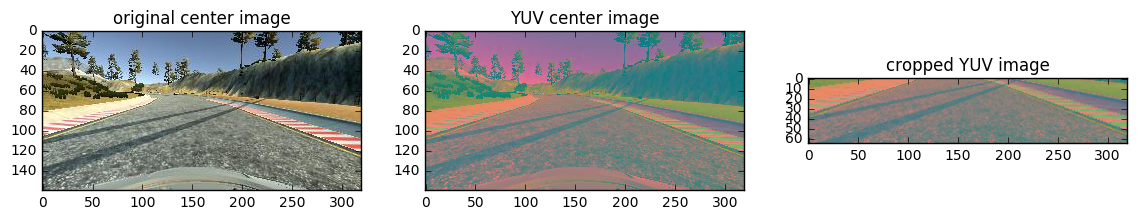

In [74]:
image = cv2.imread('./data/IMG/' + lines[0][0].split('\\')[-1])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
cropping_output = K.function([model.layers[0].input], [model.layers[0].output])

cropped_image = cropping_output([image_yuv[None,...]])[0]
#compare_images(image, np.uint8(cropped_image.reshape(cropped_image.shape[1:])))
#compare_images(image, image2)
plotImages(1,3, [image_rgb, image_yuv, np.uint8(cropped_image.reshape(cropped_image.shape[1:]))],
           ['original center image', 'YUV center image', 'cropped YUV image'])

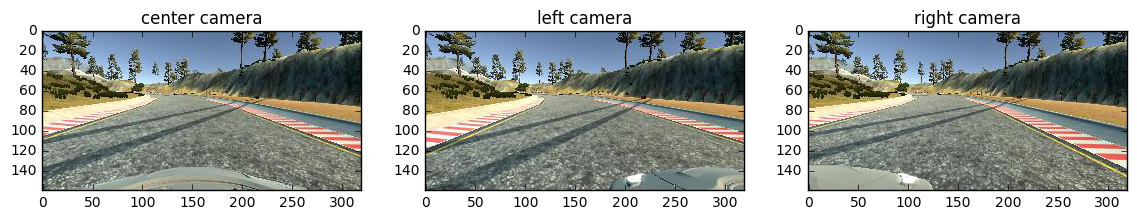

In [70]:
center = cv2.cvtColor(cv2.imread('./data/IMG/' + lines[0][0].split('\\')[-1]), cv2.COLOR_BGR2RGB)
left = cv2.cvtColor(cv2.imread('./data/IMG/' + lines[0][1].split('\\')[-1]), cv2.COLOR_BGR2RGB)
right = cv2.cvtColor(cv2.imread('./data/IMG/' + lines[0][2].split('\\')[-1]), cv2.COLOR_BGR2RGB)

plotImages(1,3, [center, left, right], ['center camera', 'left camera', 'right camera'])